# 5. Convolutional Neural Networks (CNN)

In [85]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

from minisom import MiniSom
import copy

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [118]:
# Data folder
data_dir = "./cmdb/"

# Create an image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.20
)

# Connect generator to data source
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
dataflow_kwargs = dict(
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    interpolation = "bilinear"
)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    data_dir, subset = "training", shuffle = True,
    **dataflow_kwargs
)

# Cross-validation images
valid_datagen = train_datagen
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset = "validation", shuffle = False,
    **dataflow_kwargs
)

# Test data generator
test_datagen = train_datagen
test_generator = test_datagen.flow_from_directory(
    data_dir, subset = "training", shuffle = True,
    target_size = IMAGE_SIZE, interpolation = "bilinear"
)

# Prepare a map for indexing labels
labels_idx = train_generator.class_indices
idx_labels = dict((v, k) for k,v in labels_idx.items())
print(idx_labels)

# Inspect the shape of items generated
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break # only one

Found 28 images belonging to 4 classes.
Found 4 images belonging to 4 classes.
Found 28 images belonging to 4 classes.
{0: 'bagel', 1: 'chihuahua', 2: 'dog', 3: 'muffin'}
(8, 224, 224, 3)
(8, 4)


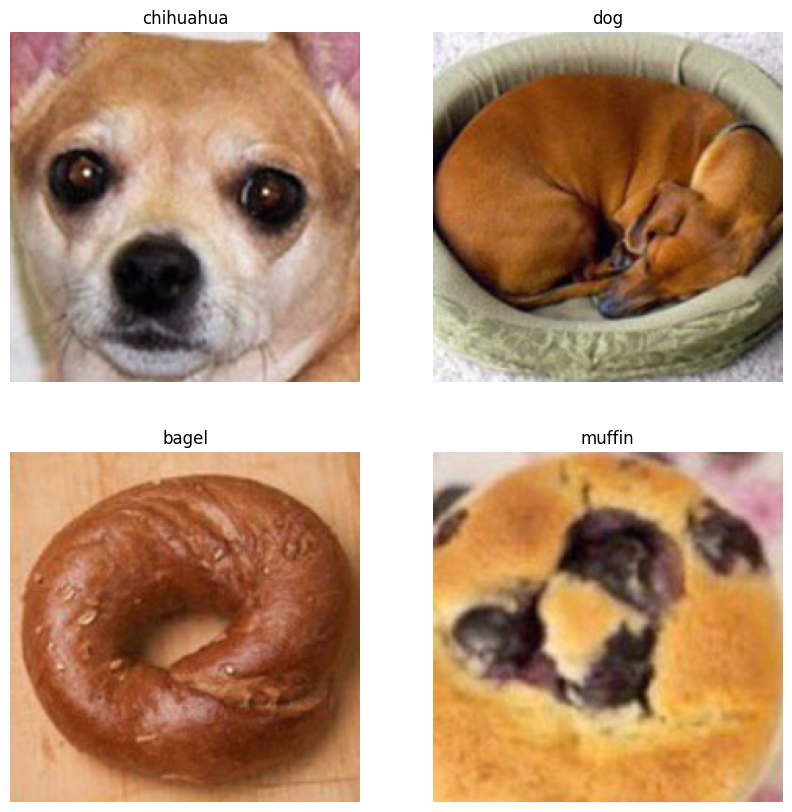

In [119]:
# Inspecting Resized Images
import matplotlib.pyplot as plt
import numpy as np

# Get one batch
image_batch, label_batch = next(iter(train_generator))

# Print the images from this batch
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for img, lbl, ax in zip(image_batch, label_batch, axes):
  ax.imshow(img)
  label_num = np.argmax(lbl)
  label = idx_labels[label_num]
  ax.set_title(label)
  ax.axis('off')
plt.show()


In [120]:
# Just to have short codes
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Building and training a model
model = tf.keras.Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = IMAGE_SIZE + (3,)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), activation = 'tanh'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))

model.summary()

# Compile
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
   optimizer = tf.keras.optimizers.Adam(learning_rate=4e-2), # M1/M2
   #optimizer = tf.keras.optimizers.Adam(), # Others
   metrics = ['accuracy']
)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │    95,551,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,646,020 (364.86 MB)

 Trainable params: 95,646,020 (364.86 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Define variables for training
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# Train
history = model.fit(
    train_generator,
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = validation_steps,
    verbose = 1)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1375 - loss: 6025.1328 - val_accuracy: 0.2500 - val_loss: 22806.9961
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1250 - loss: 31972.1133 - val_accuracy: 0.2500 - val_loss: 60283.4883
Epoch 3/20


2024-05-11 22:31:18.631366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 850ms/step - accuracy: 0.2250 - loss: 51805.8789 - val_accuracy: 0.2500 - val_loss: 7562.8164
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1250 - loss: 6948.4443 - val_accuracy: 0.2500 - val_loss: 4979.3438
Epoch 5/20


2024-05-11 22:31:22.328587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step - accuracy: 0.2250 - loss: 8743.7314 - val_accuracy: 0.2500 - val_loss: 13056.8965
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1250 - loss: 18473.9082 - val_accuracy: 0.2500 - val_loss: 6358.3848
Epoch 7/20


2024-05-11 22:31:25.859623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 847ms/step - accuracy: 0.3469 - loss: 13473.8379 - val_accuracy: 0.2500 - val_loss: 9024.2246
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.0000e+00 - loss: 8856.8242 - val_accuracy: 0.2500 - val_loss: 8183.2622
Epoch 9/20


2024-05-11 22:31:29.520137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.2031 - loss: 9212.0508 - val_accuracy: 0.2500 - val_loss: 7205.8086
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7500 - loss: 424.9468 - val_accuracy: 0.2500 - val_loss: 11757.1123
Epoch 11/20


2024-05-11 22:31:33.130132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 756ms/step - accuracy: 0.3271 - loss: 10255.4707 - val_accuracy: 0.2500 - val_loss: 7127.4629
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1250 - loss: 16088.4863 - val_accuracy: 0.2500 - val_loss: 1515.8304
Epoch 13/20


2024-05-11 22:31:36.498048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 800ms/step - accuracy: 0.2135 - loss: 3755.7261 - val_accuracy: 0.2500 - val_loss: 2542.7910
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7500 - loss: 294.8972 - val_accuracy: 0.2500 - val_loss: 1988.0647
Epoch 15/20


2024-05-11 22:31:39.655844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.2250 - loss: 2203.4895 - val_accuracy: 0.2500 - val_loss: 640.4649
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3750 - loss: 188.1988 - val_accuracy: 0.2500 - val_loss: 305.9261
Epoch 17/20


2024-05-11 22:31:42.855503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1792 - loss: 291.7376 - val_accuracy: 0.2500 - val_loss: 1.3946
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3750 - loss: 1.3802 - val_accuracy: 0.2500 - val_loss: 1.3950
Epoch 19/20


2024-05-11 22:31:47.535072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 768ms/step - accuracy: 0.2250 - loss: 1.3731 - val_accuracy: 0.2500 - val_loss: 1.3961
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3750 - loss: 1.4519 - val_accuracy: 0.2500 - val_loss: 1.3961


2024-05-11 22:31:51.075654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'verbose': 1, 'epochs': 20, 'steps': 3}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


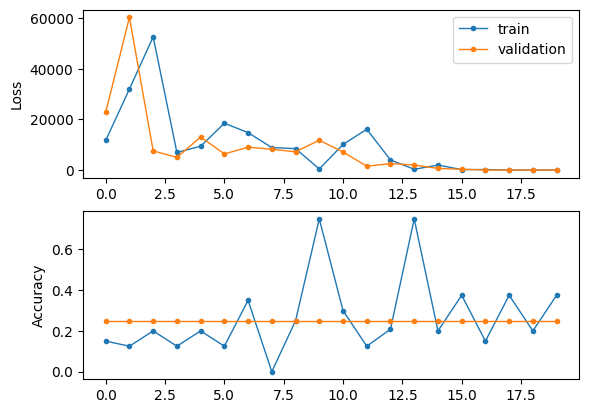

In [123]:
# Show history
print(history.params)
print(history.history.keys())

_, axs = plt.subplots(2, 1)
axs[0].plot(history.history['loss'], marker= '.', linewidth = 1)
axs[0].plot(history.history['val_loss'], marker= '.', linewidth = 1)
axs[0].set_ylabel(r"Loss")
axs[1].plot(history.history['accuracy'], marker= '.', linewidth = 1)
axs[1].plot(history.history['val_accuracy'], marker= '.', linewidth = 1)
axs[1].set_ylabel(r"Accuracy")
axs[0].legend(["train", "validation"], loc = "upper right")
plt.show()

In [124]:
# Evaluate the model
score = model.evaluate(valid_generator, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.396148443222046
Test accuracy: 0.25


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


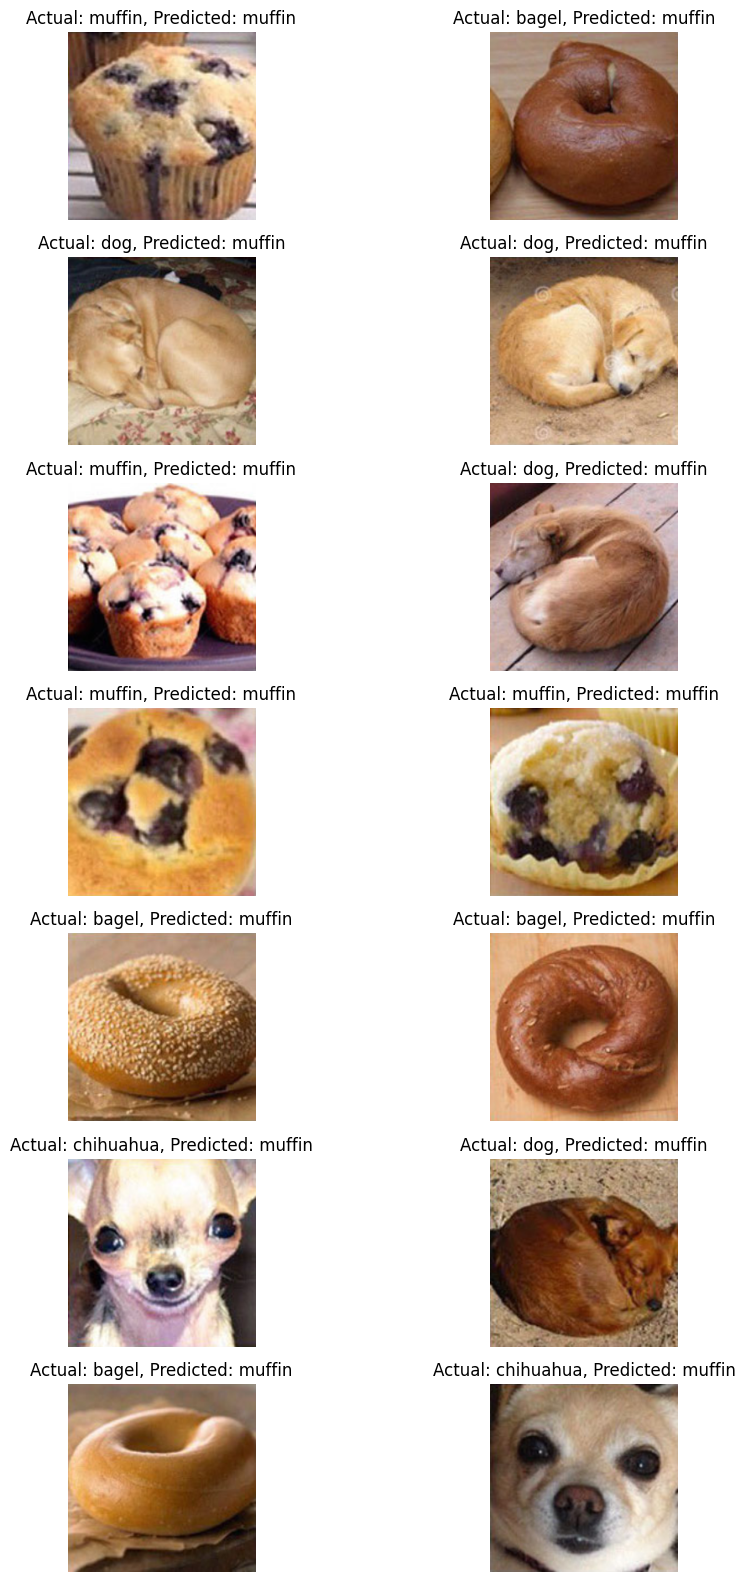

In [125]:
# Get a sample batch
sample_test_images, ground_truth_labels = next(iter(test_generator))

# Use it to predict classes
y_pred = model.predict(sample_test_images)
pred_idx = tf.math.argmax(y_pred, axis = -1).numpy()
print(pred_idx)

# Print images and resulting classes
fig, axes = plt.subplots(7, 2, figsize=(10, 20))
axes = axes.flatten()

actual = []
predicted = []
for img, lbl, pred_id, ax in zip(sample_test_images, ground_truth_labels, pred_idx, axes):
  ax.imshow(img)
  label_num = np.argmax(lbl)

  actual.append(label_num)
  predicted.append(pred_id)

  label = "Actual: {}, Predicted: {}".format(
      idx_labels[label_num], idx_labels[pred_id]
  )
  ax.set_title(label)
  ax.axis('off')
plt.show()


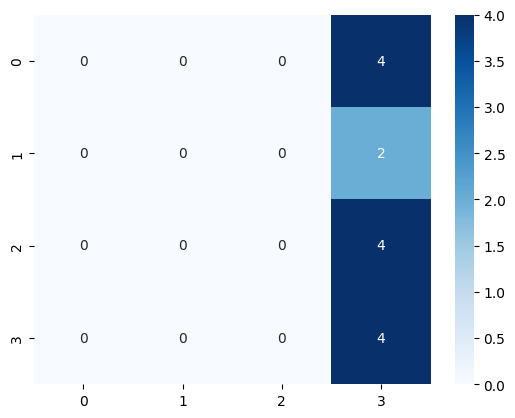

In [127]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual, predicted)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.show()

# Clasificación de Reseñas de Películas
La premisa es que cada reseña de película puede ser positiva o negativa, con base en el contenido de la reseña.


## Carga del Dataset
Ten en cuenta que el valor `num_words=10000` corresponde a usar solo las primeras 10000 palabras más frecuentes en el dataset de entrenamiento.


In [128]:
# Inicialmente estaba en 10000 pero en COLAB Free no alcanza a entrenar
NUM_WORDS=5000 

In [129]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=NUM_WORDS)

Teniendo en cuenta que ninguna palabra puede exceder el índice 10000, como máximo tendremos este índice en los conjuntos de entrenamiento y prueba.

In [130]:
max([max(sequence) for sequence in train_data])

4999

Ahora veamos la primera reseña en el dataset de entrenamiento y su clasificación

In [131]:
print("Review: ", train_data[0])
print("Classification:", 'Positive' if train_labels[0] else 'Negative')

Review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
Classification: Positive


Como puedes notar, el review es una lista de números o índices de palabras. Sin embargo, podemos definir una función para decodificar cualquier reseña. (Ten en cuenta que alguna palabra no tan frecuente puede desaparecer.)

In [132]:
# Cargamos el diccionario que mapea las palabras a índices enteros
word_index = imdb.get_word_index()

# Reversamos para ahora mapear índices enteros en palabras
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
    )

# Definimos una función lambda para decodificar cualquier review.
# Los primeros tres índices corresponden a `padding`, `start of sequence` y `unknown`
decoded_review = lambda review: ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in review])

In [133]:
decoded_review(train_data[2])

"? this has to be one of the worst films of the ? when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this ? excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"

## Preparación de los datos

Dado que no podemos ingresar listas de enteros en la red neuronal, debemos convertirlas primero a "tensores". Para ello, debemos hacer lo siguiente:

* Ajustar las listas para que tengan la misma longitud.
* Convertirlas en tensores de enteros con tamaño `(samples, word_indices)`.
* Usar la primera capa de la red para que maneje estos tensores, esto es, usando una capa de tipo `Embedding`.
* Emplear One-hot encode para las listas. Es decir, enmascarar con unos y ceros la lista utilizando un vector de 10000 elementos. Si la reseña es `[1, 3]`, el vector codificado será `[0, 1, 0, 1, 0, 0, ...]`.

In [134]:
import numpy as np

def vectorize_sequences(sequences, dimension=NUM_WORDS):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Como te puedes dar cuenta, con `vectorize_sequences` cumplimos las condiciones descritas antes. 

In [135]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Ahora, vectorizamos también las etiquetas y las adecuamos en términos de formato.

In [136]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Hasta este punto, ya la información está lista para ser ingresada a la red neuronal.

## Construcción de la red
En este caso, construirémos una red con dos capas ocultas, ambas con 16 elementos y una capa final con un único elemento. Fíjate en las funciones de activación, estas tienen mucho que ver con lo que hemos visto en clase.

In [137]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/Users/danny/Downloads/5-DL/5DLenv3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilamos el modelo definiendo un optimizador y la función de pérdida adecuada para clasificación binaria. Si deseas cambiar de optimizador, recuerda que puedes usar aquellos disponibles en `keras.optimizers`.

In [138]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Primero, antes de pasar a entrenar la red, debemos definir un dataset de validación. Esto se hace para monitorear la exactitud del modelo en datos que no ha utilizado antes. Para ello, creamos una colección con 10000 muestras del dataset original.

In [139]:
x_val = x_train[:NUM_WORDS]
partial_x_train = x_train[NUM_WORDS:]

y_val = y_train[:NUM_WORDS]
partial_y_train = y_train[NUM_WORDS:]

## Entrenamiento de la red
Ahora sí, procedemos a entrenar el modelo con 20 épocas, con mini-batches de 512 muestras y utilizando los datos de validación antes definidos.


In [140]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6943 - loss: 0.5898 - val_accuracy: 0.8144 - val_loss: 0.4288
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8801 - loss: 0.3423 - val_accuracy: 0.8662 - val_loss: 0.3329
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9069 - loss: 0.2573 - val_accuracy: 0.8736 - val_loss: 0.3103
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9194 - loss: 0.2180 - val_accuracy: 0.8792 - val_loss: 0.3028
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9231 - loss: 0.2051 - val_accuracy: 0.8744 - val_loss: 0.3155
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9313 - loss: 0.1862 - val_accuracy: 0.8822 - val_loss: 0.3117
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9374 - loss: 0.1688 - val_accuracy: 0.8864 - val_loss: 0.2898
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9450 - loss: 0.1523 - val_accuracy: 0.8834 - v

¿Qué información tiene `history_dict`?

In [141]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

history_dict.keys()

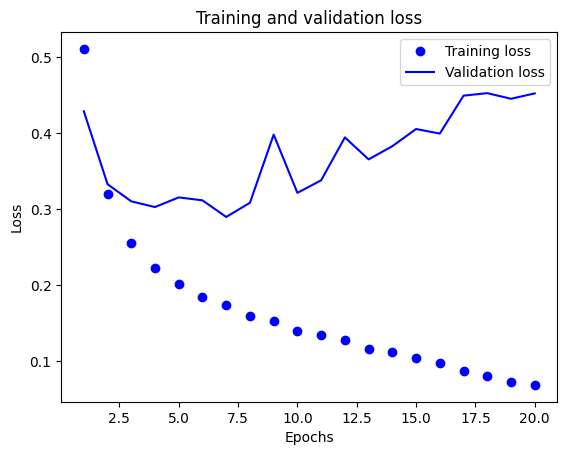

In [142]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Seguidamente, hacemos lo mismo con el accuracy durante el proceso de entrenamiento y validación

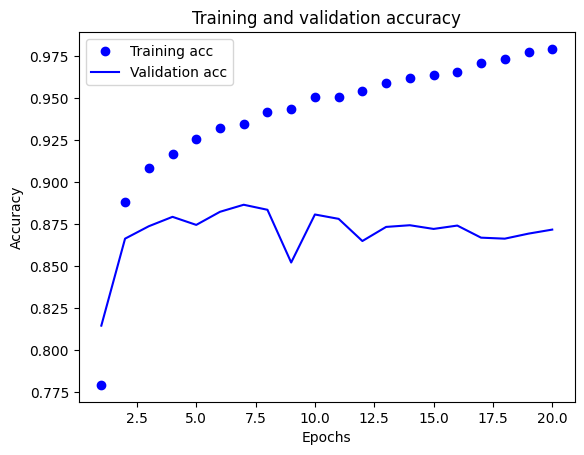

In [143]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluación del modelo

In [144]:
results = model.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8530 - loss: 0.5279


Si observamos, hemos obtenido un 83.68% de accuracy, un valor no tan bueno, si tenemos en cuenta que en el estado del arte es de 95%. ¿Es posible mejorar este valor? Sí, y la respuesta está en las gráficas que obtuvimos antes. Es decir, podemos volver a implementar el modelo y entrenamiento, pero esta vez con menos épocas, justo antes de que comience a degenerarse la dinámica del accuracy/loss.

In [145]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7117 - loss: 0.5730
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8920 - loss: 0.2962
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9127 - loss: 0.2368
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9221 - loss: 0.2139


Evaluando de nuevo, observamos que ahora nuestro accuracy es de 88.47%.

In [146]:
results = model.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8813 - loss: 0.2914


In [147]:
results

[0.28808799386024475, 0.8845999836921692]